In [2]:
%cd ..
%reload_ext autoreload
%autoreload 2

D:\ownCloud\Uni\Semester Ma 5\3D Scanning & Motion Capture (IN2354)\Project\3D-FaceReconstruction


In [3]:
import numpy as np
import trimesh
import dlib
import cv2
import pyrender
import matplotlib.pyplot as plt

from scipy import optimize
from pyquaternion import Quaternion

from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.model import BaselFaceModel
from face_reconstruction.graphics import SimpleImageRenderer, draw_pixels_to_image, cv2_to_plt
from face_reconstruction.optim import SparseOptimization, SparseOptimizationParameters

from env import DATA_PATH, MODELS_PATH

# 1. Face Model

In [4]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks_v2")
bfm_landmark_indices = list(bfm_landmarks.values())

In [5]:
n_shape_coefficients = bfm.get_n_shape_coefficients()
n_expression_coefficients = bfm.get_n_expression_coefficients()
n_color_coefficients = bfm.get_n_color_coefficients()

# 2. Input image

In [183]:
img_path = f"{DATA_PATH}/Keypoint Detection/mueller.jpg"
img = cv2.imread(img_path)

In [184]:
landmarks_img = detect_landmarks(img)

In [185]:
img_width = img.shape[1]
img_height = img.shape[0]

In [186]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
projection_matrix = perspective_camera.get_projection_matrix(width=img_width, height=img_height)
projection_matrix

array([[ 0.97930299,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.73205081,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        , -0.1       ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [187]:
initial_camera_pose = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -300], [0, 0, 0, 1]]) # position camera just in front of face

# 3. Setup rendering pipeline

In [188]:
renderer = SimpleImageRenderer(projection_matrix, img_width, img_height)

# 3.1 Test rendering

In [189]:
shape_coefficients = [0 for _ in range(n_shape_coefficients)]
expression_coefficients = [0 for _ in range(n_expression_coefficients)]
color_coefficients = [0 for _ in range(n_color_coefficients)]

face_mesh = bfm.draw_sample(shape_coefficients, expression_coefficients, color_coefficients)
face_trimesh = bfm.convert_to_trimesh(face_mesh)

In [190]:
# This is how we can reconstruct the draw_sample method in case we need differentiable rendering
reconstructed = bfm.shape_model.get_mean() + bfm.expression_model.get_mean()
reconstructed = reconstructed.reshape((-1, 3))

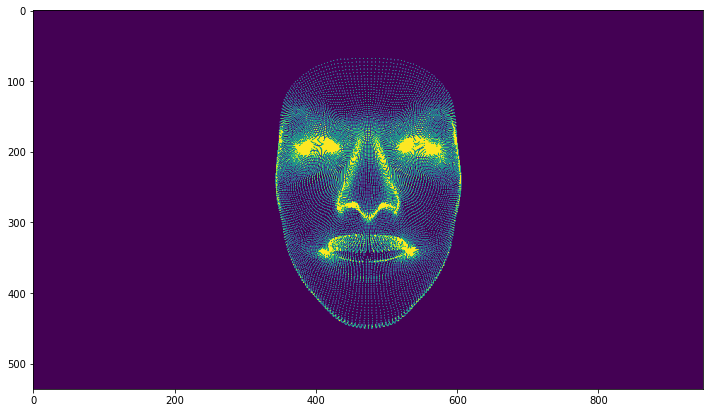

In [191]:
test_pixels = renderer.project_points(initial_camera_pose, face_mesh.vertices)

test_img = np.zeros((img_height, img_width))
draw_pixels_to_image(test_img, test_pixels)
plt.figure(figsize=(12, 8))
plt.imshow(test_img)
plt.show()

# 4. Setup optimization

In [192]:
n_params_shape = 20 # 20
n_params_expression = 10 # 10
weight_shape_params = 1000 # 10000
weight_expression_params = 1000 # 1000

In [193]:
sparse_optimization = SparseOptimization(bfm, n_params_shape, n_params_expression, weight_shape_params=weight_shape_params, weight_expression_params=weight_expression_params)
loss = sparse_optimization.create_loss(renderer, bfm_landmark_indices, landmarks_img)

In [194]:
initial_params = sparse_optimization.create_parameters(
    [0 for _ in range(n_shape_coefficients)],
    [0 for _ in range(n_expression_coefficients)],
    initial_camera_pose
)

In [195]:
assert all(sparse_optimization.create_parameters_from_theta(initial_params.to_theta()).to_theta() == initial_params.to_theta()), "OptimizationParameters is ill-defined"

In [196]:
initial_params.to_theta()

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
       -300.])

# 5. Run optimization

In [197]:
result = optimize.least_squares(loss, initial_params.to_theta(), max_nfev=100)

In [198]:
result

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
        cost: 117.14445174580214
         fun: array([ 1.03006525, -0.25716969, -1.24900088, -1.23135482,  1.46659735,
        1.12348551,  3.22082474, -1.04194293,  0.94041932, -0.49146679,
        0.2957099 ,  2.19031518, -1.6164959 ,  0.1940134 , -0.89108123,
        0.1095534 , -1.76090927, -0.77315087, -0.04300421,  0.32650507,
        1.32817068, -0.12284294,  2.90856179, -0.61016088,  0.7111779 ,
       -0.32720495,  0.19374211,  1.91754997,  0.20867932,  2.13567948,
       -0.76642727,  0.88667408, -1.78531695, -0.60093593, -1.83382043,
       -1.78827407, -0.34629689,  1.07823015, -2.88400901,  0.77715156,
       -2.72451526, -0.33138506, -1.1425733 , -2.54123022,  3.43703577,
       -0.71733483,  2.18780629,  1.30432905, -0.01635998,  1.51470874,
       -2.98524192,  1.13197894, -2.43005687, -4.

In [199]:
# Found parameters
result.x

array([-8.79638481e-04,  8.82437530e-04, -8.23321770e-03,  7.90138629e-03,
        1.14097122e-03,  1.03402671e-02,  6.71333110e-03,  2.45013507e-03,
        1.11275335e-03, -2.43866600e-03, -3.59934471e-03,  8.31954418e-03,
       -2.79503686e-05, -1.51677572e-03,  3.76066300e-03,  1.52003843e-03,
       -2.54135463e-03,  9.56952163e-04, -1.36638545e-03, -8.25766048e-03,
        3.33811972e-03,  4.73602192e-03, -3.93791381e-03,  5.43085835e-05,
       -9.40770537e-06, -7.99105186e-05, -3.38743762e-03,  1.91233220e-04,
        2.86800283e-03,  8.44251933e-03,  3.87198801e+02,  2.92884998e+01,
        4.83359241e+01,  1.81288173e+01, -4.18848682e+01,  2.20370185e+02,
       -8.67814825e+02])

In [200]:
# Final cost
result.cost

117.14445174580214

In [201]:
result.message

'`xtol` termination condition is satisfied.'

# 6. Draw mask on input image

In [202]:
params = sparse_optimization.create_parameters_from_theta(result.x)

In [203]:
face_mesh = bfm.draw_sample(
        shape_coefficients=params.shape_coefficients, 
        expression_coefficients=params.expression_coefficients, 
        color_coefficients=[0 for _ in range(n_color_coefficients)])
face_pixels = renderer.project_points(params.camera_pose, face_mesh.vertices)

In [204]:
img = cv2.imread(img_path)
img = cv2_to_plt(img)

In [205]:
pixels_bfm_landmarks = renderer.project_points(params.camera_pose, np.array(face_mesh.vertices)[bfm_landmark_indices])

In [206]:
#draw_pixels_to_image(img, face_pixels, color=1)
draw_pixels_to_image(img, landmarks_img, color=[0, 255, 0])
draw_pixels_to_image(img, pixels_bfm_landmarks, color=[255, 0, 0])

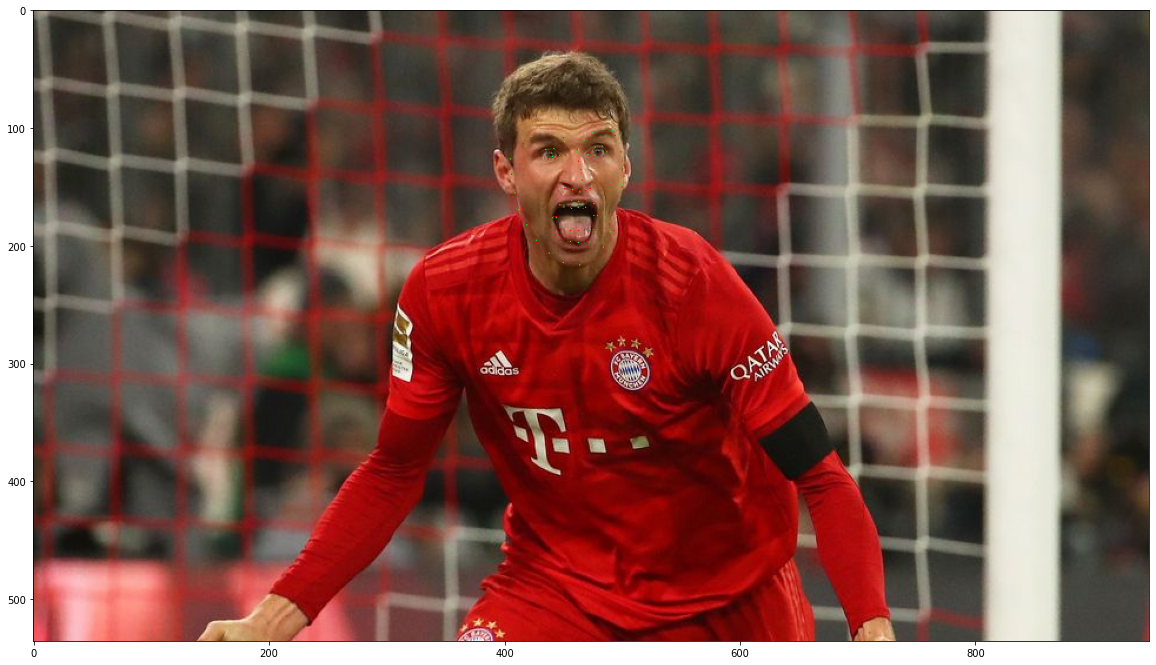

In [207]:
plt.figure(figsize=(20, 14))
plt.imshow(img)

# 7. Render full mask

## 7.1 Setup scene

In [208]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=img_width / img_height)
directional_light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)

In [209]:
face_trimesh = bfm.convert_to_trimesh(face_mesh)

In [210]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(face_trimesh), pose=params.camera_pose)
scene.add(perspective_camera)
scene.add(directional_light)

## 7.2 Interactive rendering (face only)

In [211]:
pyrender.Viewer(scene, use_raymond_lighting=True, viewport_size=(img_width, img_height))

Viewer(width=948, height=536)

## 7.3 Render face onto input image

In [212]:
r = pyrender.OffscreenRenderer(img_width, img_height)

color, depth = r.render(scene)
r.delete()

In [213]:
depth_mask = depth != 0

In [214]:
img = cv2.imread(img_path)
img = cv2_to_plt(img)
img[depth_mask] = color[depth_mask] 

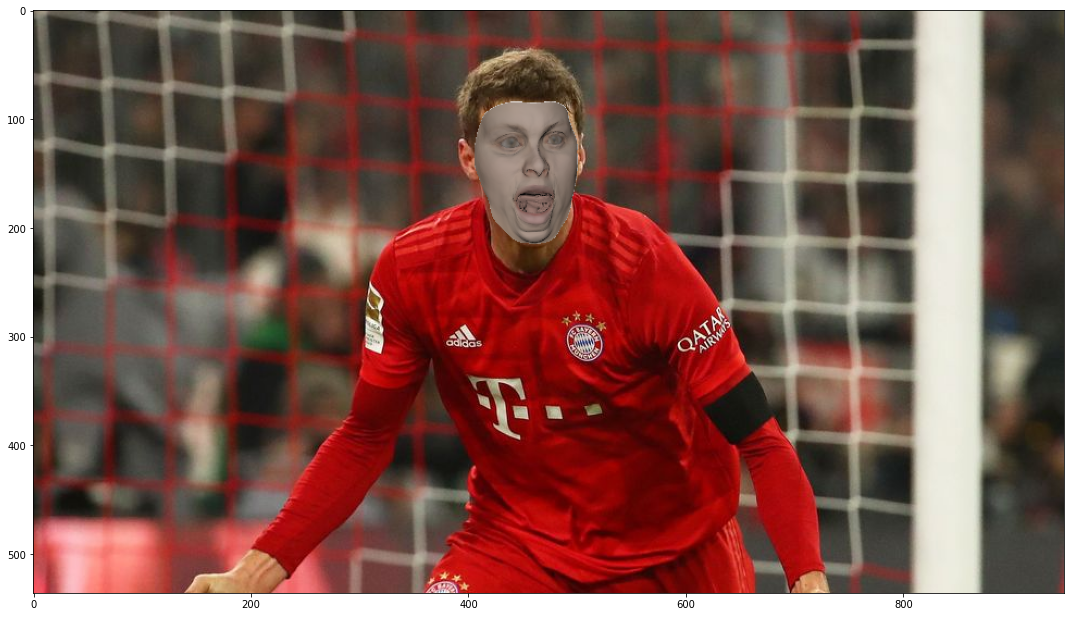

In [215]:
plt.figure(figsize=(img_width / 50, img_height / 50))
plt.imshow(img)
plt.show()